[1] 모듈 로딩 및 데이터 준비 <hr>

In [ ]:
# 기본 모듈
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib

# ML 데이터셋 및 학습 관련 모듈
from sklearn.linear_model import LinearRegression

# ML 모델 성능 지표 관련 모듈
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import root_mean_squared_error, r2_score

# CoW 활성화 : 복사와 공유 자동 설정
pd.options.mode.copy_on_write = True

# 판다스/넘파이에 지수표기법(과학적표기법) 정지 설정
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(precision=6, suppress=True)

In [77]:
## 데이터 로드
TRAIN_FILE = "../Data/world_co2_monthly_1959-01_to_2000-12.csv"
TEST_FILE  = "../Data/world_co2_monthly_2001-01_to_2013-12.csv"

trainDF = pd.read_csv(TRAIN_FILE)
testDF  = pd.read_csv(TEST_FILE)

# date 컬럼 datetime 변환
trainDF["date"] = pd.to_datetime(trainDF["date"])
testDF["date"]  = pd.to_datetime(testDF["date"])

# 월 단위(period)로 보려면
trainDF["date_m"] = trainDF["date"].dt.to_period("M")
testDF["date_m"]  = testDF["date"].dt.to_period("M")

In [78]:
# -----------------------------
# 2) 피처 엔지니어링
#   - time_idx: 시간흐름(월 단위)
#   - time_idx^2: 증가가 곡선인 걸 반영(가속)
#   - month_sin/cos: 12개월 계절성 반영
# -----------------------------
def make_features(df, base_year=1959):
    df = df.copy()
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month

    # 월 단위 시간 인덱스 (1959-01이면 0)
    df["time_idx"] = (df["year"] - base_year) * 12 + (df["month"] - 1)

    # 곡선 추세용 2차항
    df["time_idx2"] = df["time_idx"] ** 2

    # 월 계절성(원형 특성) - 12개월 주기
    theta = 2 * np.pi * df["month"] / 12.0
    df["month_sin"] = np.sin(theta)
    df["month_cos"] = np.cos(theta)

    X = df[["time_idx", "time_idx2", "month_sin", "month_cos"]]
    y = df["Value"]
    return X, y, df

X_train, y_train, trainDF2 = make_features(trainDF, base_year=1959)
X_test,  y_test,  testDF2  = make_features(testDF,  base_year=1959)

In [79]:
# -----------------------------
# 3) 모델 학습/평가
# -----------------------------
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)

pred_train = lrModel.predict(X_train)
pred_test  = lrModel.predict(X_test)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("==== 성능 ====")
print("[Train] R2 :", r2_score(y_train, pred_train))
print("[Train] RMSE:", rmse(y_train, pred_train))
print("[Test ] R2 :", r2_score(y_test, pred_test))
print("[Test ] RMSE:", rmse(y_test, pred_test))
print("[Test ] MAE :", mean_absolute_error(y_test, pred_test))

==== 성능 ====
[Train] R2 : 0.9965635753750267
[Train] RMSE: 0.9690402875824436
[Test ] R2 : 0.9908857375148571
[Test ] RMSE: 0.7572049509954955
[Test ] MAE : 0.6463832483649284


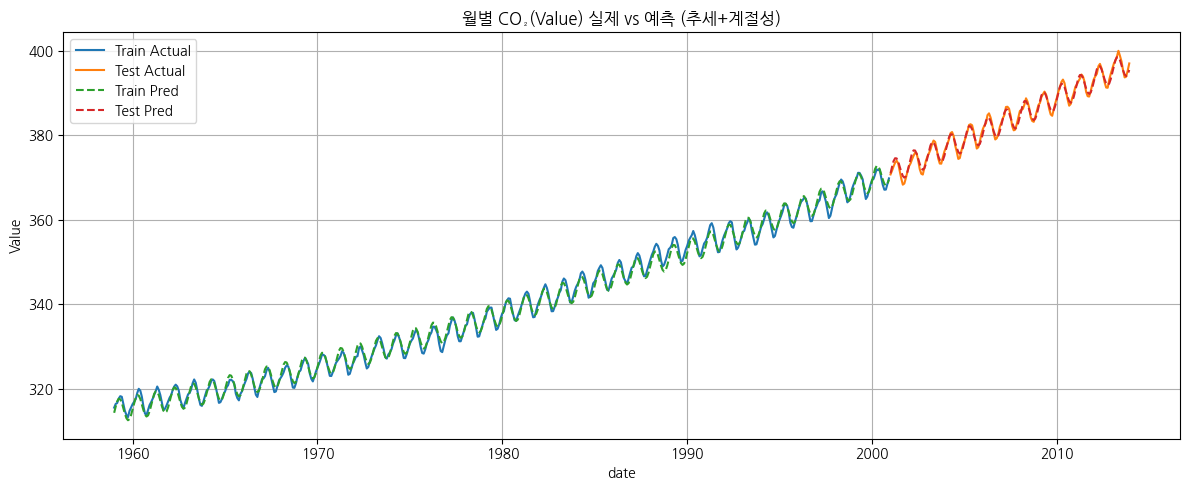

In [80]:
# -----------------------------
# 4) 시각화 (예측 vs 실제)
# -----------------------------
plt.figure(figsize=(12, 5))

# 실제값
plt.plot(trainDF2["date"], y_train, label="Train Actual")
plt.plot(testDF2["date"], y_test, label="Test Actual")

# 예측값
plt.plot(trainDF2["date"], pred_train, "--", label="Train Pred")
plt.plot(testDF2["date"], pred_test, "--", label="Test Pred")

plt.title("월별 CO₂(Value) 실제 vs 예측 (추세+계절성)")
plt.xlabel("date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [88]:
# =========================
# 0) 입력/출력 설정
# =========================
REAL_CSV  = "../Data/world_co2_monthly_1959-01_to_2000-12.csv"
REAL_CSV2 = "../Data/world_co2_monthly_2001-01_to_2013-12.csv"

OUT_CSV = "../Data/carbon_risk_timeseries.csv"

THRESHOLD_VALUE = 1000.0     # Risk=100이 되는 Value(ppm)
MAX_PRED_MONTHS = 30000      # 아주 먼 미래까지(필요하면 조절)

# =========================
# 1) 데이터 로딩 + 합치기
# =========================
df1 = pd.read_csv(REAL_CSV)
df2 = pd.read_csv(REAL_CSV2)
df = pd.concat([df1, df2], ignore_index=True)

# date 파싱 (real 구간만 Timestamp로 OK)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").reset_index(drop=True)

df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna(subset=["Value", "date"])
df = df[df["Value"] >= 100]            # 0.xx 같은 비정상 값 제거
df = df.drop_duplicates("date", keep="first")

# YearMonth를 "YYYY-MM" 문자열로
df["YearMonth"] = df["date"].dt.to_period("M").astype(str)

# =========================
# 2) 피쳐 만들기 (시간 + 계절성)
# =========================
df["t"] = np.arange(len(df))                 # 0,1,2,...
df["month"] = df["date"].dt.month            # 1~12

df["sin_m"] = np.sin(2*np.pi*df["month"]/12)
df["cos_m"] = np.cos(2*np.pi*df["month"]/12)

X = df[["t", "sin_m", "cos_m"]]
y = df["Value"]

# =========================
# 3) 모델 학습 (real 전체로 학습)
# =========================
lr = LinearRegression()
lr.fit(X, y)

# =========================
# 4) 미래 월별 예측(Value) 생성 (문자열 YearMonth로만 관리)
#    - 2014-01부터 1개월씩
# =========================
last_ym = df["date"].max().to_period("M")     # 예: 2013-12
start_year = last_ym.year
start_month = last_ym.month

# 다음 달 시작
pred_year = start_year
pred_month = start_month + 1
if pred_month == 13:
    pred_month = 1
    pred_year += 1

cur_t = int(df["t"].iloc[-1]) + 1

future_rows = []
for _ in range(MAX_PRED_MONTHS):
    # 계절성
    sin_m = np.sin(2*np.pi*pred_month/12)
    cos_m = np.cos(2*np.pi*pred_month/12)

    x_row = np.array([[cur_t, sin_m, cos_m]])
    pred_val = float(lr.predict(x_row)[0])

    # Risk 계산(100 캡핑은 나중에)
    pred_risk = 100.0 * (pred_val / THRESHOLD_VALUE)

    ym_str = f"{pred_year:04d}-{pred_month:02d}"
    future_rows.append((ym_str, pred_val, pred_risk))

    # Risk=100 도달하면 중단
    if pred_risk >= 100.0:
        break

    # 다음 달로 증가
    pred_month += 1
    if pred_month == 13:
        pred_month = 1
        pred_year += 1
    cur_t += 1

future_df = pd.DataFrame(future_rows, columns=["YearMonth", "Value", "Risk_raw"])

# =========================
# 5) Risk 스케일링 + 최종 CSV
# =========================
def value_to_risk(v, thr=THRESHOLD_VALUE):
    r = 100.0 * (v / thr)
    return min(100.0, max(0.0, r))

real_out = df[["YearMonth", "Value"]].copy()
real_out["Risk"] = real_out["Value"].apply(value_to_risk)
real_out["Type"] = "real"

pred_out = future_df[["YearMonth", "Value"]].copy()
pred_out["Risk"] = pred_out["Value"].apply(value_to_risk)
pred_out["Type"] = "pred"

out_final = pd.concat([real_out, pred_out], ignore_index=True)
out_final = out_final[["YearMonth", "Risk", "Type"]].copy()
out_final["Risk"] = out_final["Risk"].round(2)

out_final.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

print("저장 완료:", OUT_CSV)
print("real 마지막:", out_final[out_final["Type"]=="real"].tail(1))
print("pred 처음:", out_final[out_final["Type"]=="pred"].head(1))
print("pred 마지막(임계 도달 지점):", out_final[out_final["Type"]=="pred"].tail(1))


c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

저장 완료: ../Data/carbon_risk_timeseries.csv
real 마지막:     YearMonth     Risk  Type
659   2013-12 39.70000  real
pred 처음:     YearMonth     Risk  Type
660   2014-01 39.11000  pred
pred 마지막(임계 도달 지점):      YearMonth      Risk  Type
5510   2418-03 100.00000  pred


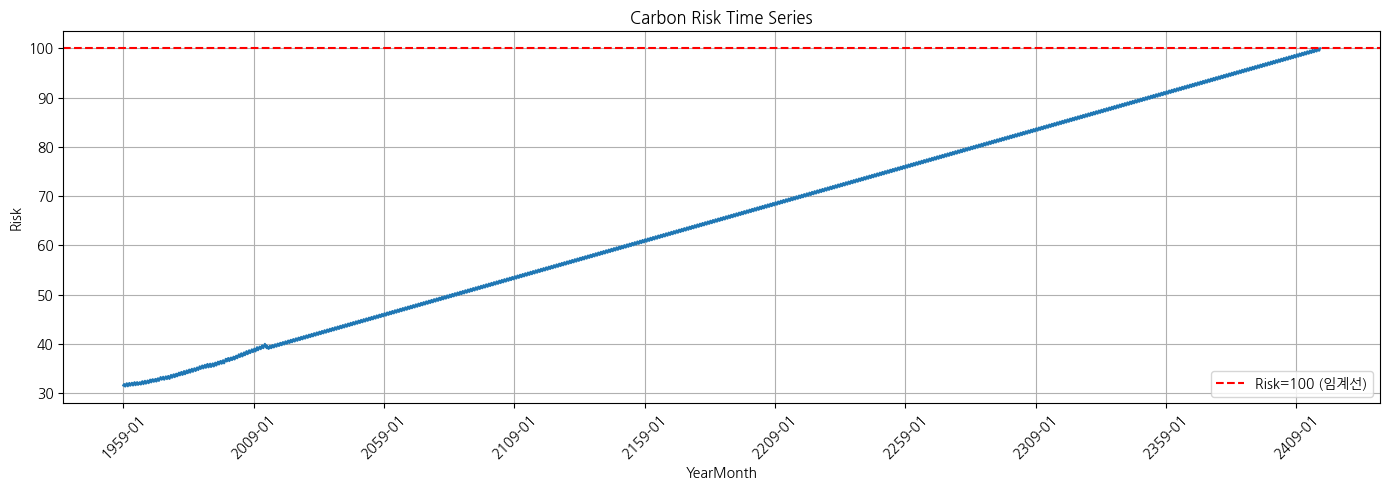

In [ ]:
# out_final 로드했다고 가정 (또는 위에서 만든 out_final 그대로 사용)
# out_final = pd.read_csv(OUT_CSV)

x = np.arange(len(out_final))
y = out_final["Risk"].values

plt.figure(figsize=(14,5))
plt.plot(x, y)

# 임계선 Risk=100
plt.axhline(100, linestyle="--", color="r", label="Risk=100 (임계선)")

# 50년 단위 라벨 찍기 (매 600개월)
step = 50 * 12
tick_pos = np.arange(0, len(out_final), step)
tick_lab = out_final["YearMonth"].iloc[tick_pos].tolist()

plt.xticks(tick_pos, tick_lab, rotation=45)
plt.xlabel("YearMonth")
plt.ylabel("Risk")
plt.title("Carbon Risk Time Series")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()